<a href="https://colab.research.google.com/github/connixu/120-Data-Science-Interview-Questions/blob/master/name_to_race/Evaluation/cascaded_model/Cascade_Models_11_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Name to Race Cascade Models**
--- 
11/16/2021
This notebook includes the new cascade models for Name to Race Inference Work. I have made this a seperate notebook due to the amount of information in the previous jupyter notebook [Name_to_Race_final.ipynb](). Changes will be merged to the previous notebook and pushed to github. 

Therefore the current notebook covers *model performance on combined train-test data* for *cascade* and *preprocessed cascade* models. 
2. Best Cascade
  - White vs. Nonwhite: Namsor AND NamePrism
  - Black vs. Nonblack: Namsor AND Combined_Oversample_LR
  - Hispanic vs. Asian: Namsor AND Combined_Oversample_LR
4. Names with no overlap as preprocessing + cascade

## Notebook Setup

In [1]:
import sys
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, \
    precision_score
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cascade Data Load

In [12]:
cascade_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/pre_result/cascade_df.csv') 

print(cascade_df.shape[0])
cascade_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1321169


,Unnamed: 0,Unnamed: 0.1,name_last,race,origin,name_first,__name,namsor_race,probNamSor,name_full,actual_race,nameprism_race,ethnicolor_race,combined_oversample_race,inmate_race
0,0,31392,loy,white,wikipedia,julien,Loy Julien,asian,0.585072,julien loy,white,white,white,asian,black
1,1,31393,meÄ?Ã­Å,white,wikipedia,miloslav,Meä?Ã­Å Miloslav,asian,0.494222,miloslav me,white,white,white,white,white
2,2,31394,ghoraguli,asian,wikipedia,moheener,Ghoraguli Moheener,asian,0.830798,moheener ghoraguli,asian,white,asian,asian,white
3,3,31395,dubey,asian,wikipedia,vijay,Dubey Vijay,asian,0.975499,vijay dubey,asian,asian,white,asian,white
4,4,31396,gohil,asian,wikipedia,manav,Gohil Manav,asian,0.975499,manav gohil,asian,asian,asian,asian,white


In [4]:
preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
preprocess_df.head()

,Unnamed: 0,name_full_clean,preprocessed_race
0,1,amirthanayagam indran,asian
1,2,dancing rochanavibhata watchara,asian
2,3,dinkar ramdhari,asian
3,4,fleurime michel betty,black
4,5,franklin chaquisha,black


## Functions (Cascade, Scoring and Visualization) 

In [13]:
def scoring(df,actual_race,predicted_race):
  print(recall_score(df[actual_race], df[predicted_race], average=None))
  print(f1_score(df[actual_race], df[predicted_race], average=None))
  print(accuracy_score(df[actual_race], df[predicted_race]))

In [14]:
def clean_name_data(df, name_first = 'name_first', name_last = 'name_last', fullname_column = False, name_full = 'name_full'):
  
  # remove items that are underscores, special characters, and digits. 
  if fullname_column == False: 
    df['cleaned_first_name'] = df[name_first].astype(str).str.lower().str.replace('[^\w\s]',' ').str.replace('_'," ").str.replace('[0-9]',' ')
    df['cleaned_last_name'] = df[name_last].astype(str).str.lower().str.replace('[^\w\s]',' ').str.replace('_'," ").str.replace('[0-9]',' ')
    df['name_full_clean'] = df['cleaned_last_name'] + " " + df['cleaned_first_name']

  else: 
    df['name_full_clean'] = df['name_full_clean'].astype(str).str.lower().str.replace('[^\w\s]',' ').str.replace('_'," ").str.replace('[0-9]',' ')

  #df['ascii_only'] = np.where(only_english(df['cleaned_name_full'])==False,False,True)

  return df 

#### Cascade 1 

In [15]:
def cascaded_predictor_1(df, preprocess = False): 
  """
  Function to compile cascade 
  White/NonWhite (nameprism & namsor) -> 
  Hispanic/Non-Hispanic (LR-Oversample & namsor) -> 
  Black/Asian (LR-Oversample & namsor)
  """
  # Step 1: White vs. Other 
    # note - nameprism precision is a bit lower with white names. 
  df['white_other_predicted'] = np.where((((df['nameprism_race'] == 'white') &
                                             (df['namsor_race'] == 'white'))|\
                                            ((df['nameprism_race'] == 'white') &
                                             (df['namsor_race'].isnull() == True))|\
                                            ((df['nameprism_race'].isnull() == True) &
                                             (df['namsor_race'] == 'white'))), 'white', 'nonwhite')
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['white_other_predicted'] == 'white'),'white',\
                                               np.where(((df['combined_oversample_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['combined_oversample_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonwhite'))
  # Step 3: Asian vs Black 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonwhite'),df['hispanic_other_predicted'],
                                            np.where(((df['combined_oversample_race']=='black') & (df['namsor_race']=='black'))|\
                                                     ((df['combined_oversample_race'] == 'black') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'black')), 'black', 'asian')) 
  
  df = df.drop(columns = ['white_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
  
  return df 

#### Cascade 1 (or statement at first step) 

In [16]:
def cascaded_predictor_1_or(df, preprocess = False): 
  """
  Function to compile cascade 
  White/NonWhite (nameprism OR namsor) -> 
  Hispanic/Non-Hispanic (LR-Oversample & namsor) -> 
  Black/Asian (LR-Oversample & namsor)
  """
  # Step 1: White vs. Other 
    # note - nameprism precision is a bit lower with white names. 
  df['white_other_predicted'] = np.where((((df['nameprism_race'] == 'white') |
                                             (df['namsor_race'] == 'white'))|\
                                            ((df['nameprism_race'] == 'white') |
                                             (df['namsor_race'].isnull() == True))|\
                                            ((df['nameprism_race'].isnull() == True) |
                                             (df['namsor_race'] == 'white'))), 'white', 'nonwhite')
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['white_other_predicted'] == 'white'),'white',\
                                               np.where(((df['combined_oversample_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['combined_oversample_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonwhite'))
  # Step 3: Asian vs Black 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonwhite'),df['hispanic_other_predicted'],
                                            np.where(((df['combined_oversample_race']=='black') & (df['namsor_race']=='black'))|\
                                                     ((df['combined_oversample_race'] == 'black') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'black')), 'black', 'asian')) 
  
  df = df.drop(columns = ['white_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
  
  return df 

#### Cascade 2 

In [17]:
def cascaded_predictor_2(df, preprocess = False): 
  """
  Function to compile cascade 
  Asian/NonAsian (combined_oversample_race & namsor) -> 
  Hispanic/Non-Hispanic (LR-Oversample & namsor) -> 
  White/Black (nameprism & namsor)
  """
  # Step 1: Asian vs. Other 
  df['asian_other_predicted'] = np.where((((df['combined_oversample_race'] == 'asian') &
                                             (df['namsor_race'] == 'asian'))|\
                                            ((df['combined_oversample_race'] == 'asian') &
                                             (df['namsor_race'].isnull() == True))|\
                                            ((df['combined_oversample_race'].isnull() == True) &
                                             (df['namsor_race'] == 'asian'))), 'asian', 'nonasian')
  
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['asian_other_predicted'] == 'asian'),'asian',\
                                               np.where(((df['combined_oversample_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['combined_oversample_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonasian'))
  
  # Step 3: White vs Black - the idea here is to increase the pool for Black names. 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonasian'),df['hispanic_other_predicted'],
                                            np.where(((df['nameprism_race']=='white') & (df['namsor_race']=='white'))|\
                                                     ((df['nameprism_race'] == 'white') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['nameprism_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'white')), 'white', 'black')) 
  
  df = df.drop(columns = ['asian_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
  return df 

#### Cascade 3

In [20]:
def cascaded_predictor_3(df, preprocess = False): 
  """
  Function to compile cascade 
  Asian/NonAsian (combined_oversample_race & namsor) -> 
  Hispanic/Non-Hispanic (LR-Oversample & namsor) -> 
  Black/White (inmate & namsor)
  """
  # Step 1: Asian vs. Other 
  df['asian_other_predicted'] = np.where((((df['combined_oversample_race'] == 'asian') &
                                             (df['namsor_race'] == 'asian'))|\
                                            ((df['combined_oversample_race'] == 'asian') &
                                             (df['namsor_race'].isnull() == True))|\
                                            ((df['combined_oversample_race'].isnull() == True) &
                                             (df['namsor_race'] == 'asian'))), 'asian', 'nonasian')
  
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['asian_other_predicted'] == 'asian'),'asian',\
                                               np.where(((df['combined_oversample_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['combined_oversample_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonasian'))
  
  # Step 3: White vs Black - the idea here is to increase the pool for Black names. 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonasian'),df['hispanic_other_predicted'],
                                            np.where(((df['inmate_race']=='black') & (df['namsor_race']=='black'))|\
                                                     ((df['inmate_race'] == 'black') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['inmate_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'black')), 'black', 'white')) 
  
  df = df.drop(columns = ['asian_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
  return df 

cascade_3 = cascaded_predictor_3(cascade_df)
cascade_3 = cascade_3.rename(columns={'cascade_prediction': 'cascade_prediction_3'})
cascade_3_scoring = scoring(cascade_3,'race','cascade_prediction_3')

[0.66519791 0.55909589 0.83762984 0.85459417]
[0.54787395 0.55815947 0.83121586 0.86223547]
0.8054139932135859


In [21]:
# Sidd also tried to use different ordering (white -> asian) 
def cascaded_predictor_3_Sidd(df, preprocess = False): 
  # Step 1: White vs. Other 
  # note - nameprism precision is a bit lower with white names. 
  df['white_other_predicted'] = np.where(df['namsor_race'] == 'white', 'white', 'nonwhite')
  
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['white_other_predicted'] == 'white'),'white',\
                                               np.where(((df['combined_oversample_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['combined_oversample_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonwhite'))
  # Step 3: Asian vs Black 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonwhite'),df['hispanic_other_predicted'],
                                            np.where(((df['combined_oversample_race']=='black') & (df['namsor_race']=='black'))|\
                                                     ((df['combined_oversample_race'] == 'black') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'black')), 'black', 'asian')) 
  
  df = df.drop(columns = ['white_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
  
  return df 

cascade_3 = cascaded_predictor_3(cascade_df)
cascade_3 = cascade_3.rename(columns={'cascade_prediction': 'cascade_prediction_3'})
cascade_3_scoring = scoring(cascade_3,'race','cascade_prediction_3')

cascade_3_SS = cascaded_predictor_3_SS(cascade_df)
cascade_3_SS_scoring = scoring(cascade_3_SS, 'race', 'cascade_prediction')

[0.66519791 0.55909589 0.83762984 0.85459417]
[0.54787395 0.55815947 0.83121586 0.86223547]
0.8054139932135859
[0.77190277 0.69008765 0.83762984 0.7460814 ]
[0.24846203 0.59829657 0.83121586 0.82867113]
0.753757467818273


#### Cascade 4

In [24]:
def cascaded_predictor_4(df, preprocess = False): 
  """
  Function to compile cascade - selecting by precision for first group 
  Asian/NonAsian (ethnicolor & nameprism) -> 
  Hispanic/Non-Hispanic (LR-Oversample & namsor) -> 
  Black/White (inmate & namsor)
  """
  # Step 1: Asian vs. Other 
  # selected predictors this time in first round with higher precisions for the first group 
  df['asian_other_predicted'] = np.where((((df['ethnicolor_race'] == 'asian') &
                                             (df['nameprism_race'] == 'asian'))|\
                                            ((df['ethnicolor_race'] == 'asian') &
                                             (df['nameprism_race'].isnull() == True))|\
                                            ((df['ethnicolor_race'].isnull() == True) &
                                             (df['nameprism_race'] == 'asian'))), 'asian', 'nonasian')
  
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['asian_other_predicted'] == 'asian'),'asian',\
                                               np.where(((df['combined_oversample_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['combined_oversample_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonasian'))
  
  # Step 3: White vs Black - the idea here is to increase the pool for Black names. 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonasian'),df['hispanic_other_predicted'],
                                            np.where(((df['inmate_race']=='black') & (df['namsor_race']=='black'))|\
                                                     ((df['inmate_race'] == 'black') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['inmate_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'black')), 'black', 'white')) 
  
  df = df.drop(columns = ['asian_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
  
  return df 

cascade_4 = cascaded_predictor_4(cascade_df)
cascade_4 = cascade_4.rename(columns={'cascade_prediction': 'cascade_prediction_4'})
cascade_4_scoring = scoring(cascade_4,'race','cascade_prediction_4')

[0.17555262 0.55902741 0.83760247 0.87083928]
[0.28927545 0.55811752 0.83120564 0.86235105]
0.806186793665307


#### Cascade 4 (or statement at first step) 

In [25]:
def cascaded_predictor_4_or(df, preprocess = False): 
  """
  Function to compile cascade - selecting by precision for first group 
  Asian/NonAsian (ethnicolor OR nameprism) -> 
  Hispanic/Non-Hispanic (LR-Oversample & namsor) -> 
  Black/White (inmate & namsor)
  """
  # Step 1: Asian vs. Other 
  # selected predictors this time in first round with higher precisions for the first group 
  df['asian_other_predicted'] = np.where((((df['ethnicolor_race'] == 'asian') |
                                             (df['nameprism_race'] == 'asian'))|\
                                            ((df['ethnicolor_race'] == 'asian') |
                                             (df['nameprism_race'].isnull() == True))|\
                                            ((df['ethnicolor_race'].isnull() == True) |
                                             (df['nameprism_race'] == 'asian'))), 'asian', 'nonasian')
  
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['asian_other_predicted'] == 'asian'),'asian',\
                                               np.where(((df['combined_oversample_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['combined_oversample_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonasian'))
  
  # Step 3: White vs Black - the idea here is to increase the pool for Black names. 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonasian'),df['hispanic_other_predicted'],
                                            np.where(((df['inmate_race']=='black') & (df['namsor_race']=='black'))|\
                                                     ((df['inmate_race'] == 'black') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['inmate_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'black')), 'black', 'white')) 
  
  df = df.drop(columns = ['asian_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
  
  return df 

#### Cascade 5

In [26]:
def cascaded_predictor_5(df, preprocess = False): 
  """
  Function to compile cascade 
  Black/NonBlack (ethnicolor & nameprism) -> 
  Hispanic/Non-Hispanic (nameprism & namsor) -> 
  Asian/White (LR-Oversample & namsor)
  """
  # Step 1: Black vs. Other 
  # selected predictors this time in first round with higher precisions for the first group 
  df['black_other_predicted'] = np.where((((df['ethnicolor_race'] == 'black') &
                                             (df['nameprism_race'] == 'black'))|\
                                            ((df['ethnicolor_race'] == 'black') &
                                             (df['nameprism_race'].isnull() == True))|\
                                            ((df['ethnicolor_race'].isnull() == True) &
                                             (df['nameprism_race'] == 'black'))), 'black', 'nonblack')
  
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['black_other_predicted'] == 'black'),'black',\
                                               np.where(((df['nameprism_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['nameprism_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['nameprism_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonblack'))
  
  # Step 3: Asian vs White 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonblack'),df['hispanic_other_predicted'],
                                            np.where(((df['combined_oversample_race']=='asian') & (df['namsor_race']=='asian'))|\
                                                     ((df['combined_oversample_race'] == 'asian') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'asian')), 'asian', 'white')) 
  
  df = df.drop(columns = ['black_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
    
  return df 

cascade_5 = cascaded_predictor_5(cascade_df)
cascade_5 = cascade_5.rename(columns={'cascade_prediction': 'cascade_prediction_5'})
cascade_5_scoring = scoring(cascade_5,'race','cascade_prediction_5')

[0.66270104 0.07478245 0.36950581 0.96218931]
[0.54793023 0.13714258 0.5081525  0.8304052 ]
0.7301624546140577


#### Cascade 5 (or statement at first step) 

In [27]:
def cascaded_predictor_5_or(df, preprocess = False): 
  """
  Function to compile cascade 
  Black/NonBlack (ethnicolor OR nameprism) -> 
  Hispanic/Non-Hispanic (nameprism & namsor) -> 
  Asian/White (LR-Oversample & namsor)
  """
  # Step 1: Black vs. Other 
  # selected predictors this time in first round with higher precisions for the first group 
  df['black_other_predicted'] = np.where((((df['ethnicolor_race'] == 'black') |
                                             (df['nameprism_race'] == 'black'))|\
                                            ((df['ethnicolor_race'] == 'black') |
                                             (df['nameprism_race'].isnull() == True))|\
                                            ((df['ethnicolor_race'].isnull() == True) |
                                             (df['nameprism_race'] == 'black'))), 'black', 'nonblack')
  
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['black_other_predicted'] == 'black'),'black',\
                                               np.where(((df['nameprism_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['nameprism_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['nameprism_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonblack'))
  
  # Step 3: Asian vs White 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonblack'),df['hispanic_other_predicted'],
                                            np.where(((df['combined_oversample_race']=='asian') & (df['namsor_race']=='asian'))|\
                                                     ((df['combined_oversample_race'] == 'asian') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'asian')), 'asian', 'white')) 
  
  
  df = df.drop(columns = ['black_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
    
  return df 

#### Cascade 6

In [29]:
def cascaded_predictor_6(df, preprocess = False): 
  """
  Function to compile cascade 
  Black/NonBlack (namsor & inmate) -> 
  Hispanic/Non-Hispanic (nameprism & namsor) -> 
  Asian/White (LR-Oversample & namsor)
  """
  # Step 1: Black vs. Other 
  # selected predictors this time in first round with higher precisions for the first group 
  df['black_other_predicted'] = np.where((((df['namsor_race'] == 'black') &
                                             (df['inmate_race'] == 'black'))|\
                                            ((df['namsor_race'] == 'black') &
                                             (df['inmate_race'].isnull() == True))|\
                                            ((df['namsor_race'].isnull() == True) &
                                             (df['inmate_race'] == 'black'))), 'black', 'nonblack')
  
  # Step 2: Hispanic vs Nonhispanic 
  df['hispanic_other_predicted'] = np.where((df['black_other_predicted'] == 'black'),'black',\
                                               np.where(((df['nameprism_race']=='hispanic') &\
                                                         (df['namsor_race']=='hispanic'))|\
                                                        ((df['nameprism_race'] == 'hispanic') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['nameprism_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'hispanic')), 'hispanic', 'nonhispanic_nonblack'))
  
  # Step 3: Asian vs White 
  df['cascade_prediction'] = np.where((df['hispanic_other_predicted']!= 'nonhispanic_nonblack'),df['hispanic_other_predicted'],
                                            np.where(((df['combined_oversample_race']=='asian') & (df['namsor_race']=='asian'))|\
                                                     ((df['combined_oversample_race'] == 'asian') &\
                                                         (df['namsor_race'].isnull() == True))|\
                                                        ((df['combined_oversample_race'].isnull() == True) &\
                                                         (df['namsor_race'] == 'asian')), 'asian', 'white')) 
  
  df = df.drop(columns = ['black_other_predicted','hispanic_other_predicted'])  

  if preprocess == True: 
    preprocess_df = pd.read_csv('/content/drive/MyDrive/Corporate_Climate_Name_To_Race/preprocess/preprocess_names_full.csv').rename(columns = {'race':'preprocessed_race'})
    df = clean_name_data(df)
    df = df.merge(preprocess_df, on = 'name_full_clean', how = 'left')
    df['preprocessed_cascade_prediction'] = np.where(df['preprocessed_race'].notnull(),\
                                                             df['preprocessed_race'],df['cascade_prediction'])
    
  return df 

cascade_6 = cascaded_predictor_6(cascade_df)
cascade_6 = cascade_6.rename(columns={'cascade_prediction': 'cascade_prediction_6'})
cascade_6_scoring = scoring(cascade_6,'race','cascade_prediction_6')

[0.66519791 0.55909589 0.36974303 0.87507148]
[0.54787395 0.55815947 0.50821569 0.8251133 ]
0.7414971135411139


In [30]:
def distribution_plot(df, prediction): 

  df['frequency'] = 0 # a dummy column to refer to
  total = len(df)
  counts = df.groupby([prediction]).count()
  freq_per_total = counts.div(total).reset_index()
  ax = sns.barplot(x=prediction, y='frequency', data=freq_per_total)
  
  return ax 

In [33]:
# Sidd checked for the similar scores for 'asian' and 'black' predictors 

cascade_3_and_6_merge = cascade_3.merge(cascade_6, on = 'Unnamed: 0', how = 'inner')
print(cascade_3_and_6_merge.shape)
#print(list(cascade_3_and_6_merge_3_asian.columns))
cascade_3_and_6_merge_3_asian = cascade_3_and_6_merge[cascade_3_and_6_merge['cascade_prediction_3'] == 'asian']
print(cascade_df.shape)
print(cascade_3_and_6_merge_3_asian['inmate_race_y'].unique())
print(list(cascade_3_and_6_merge.columns))
#cascade_3_asian = cascade_3[cascade_3['cascade_prediction'] == 'asian']
#print(cascade_3_asian[cascade_3_asian['inmate_race'] == 'black'].shape)
#print(cascade_3_asian.shape)
#cascade_6_asian = cascade_6[cascade_6['cascade_prediction'] == 'asian']
#print(cascade_6_asian.shape)


(1321169, 33)
(1321169, 20)
['black' 'white' 'hispanic']
['Unnamed: 0', 'Unnamed: 0.1_x', 'name_last_x', 'race_x', 'origin_x', 'name_first_x', '__name_x', 'namsor_race_x', 'probNamSor_x', 'name_full_x', 'actual_race_x', 'nameprism_race_x', 'ethnicolor_race_x', 'combined_oversample_race_x', 'inmate_race_x', 'cascade_prediction_3', 'Unnamed: 0.1_y', 'name_last_y', 'race_y', 'origin_y', 'name_first_y', '__name_y', 'namsor_race_y', 'probNamSor_y', 'name_full_y', 'actual_race_y', 'nameprism_race_y', 'ethnicolor_race_y', 'combined_oversample_race_y', 'inmate_race_y', 'asian_other_predicted', 'cascade_prediction_6', 'white_other_predicted']


# Results

### For Reference: Actual Race

Actual Race


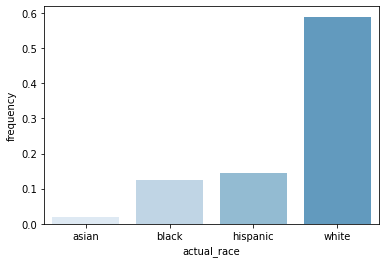

In [ ]:
print('Actual Race')
sns.set_palette('Blues')
cascade_df.actual_race = cascade_df.actual_race.str.replace('white.1','white')
distribution_plot(cascade_df,'actual_race')

## Cascade Model 1 

This was one of our original top-performing cascade models. As shown below, it goes from White to Asian with three sub-predictors at each cascade binary classification, using only nameprism, LR, and Namsor. 

In [ ]:
cascade_1 = cascaded_predictor_1(cascade_df)
help(cascaded_predictor_1)

Help on function cascaded_predictor_1 in module __main__:

cascaded_predictor_1(df, preprocess=False)
    Function to compile cascade 
    White/NonWhite (nameprism & namsor) -> 
    Hispanic/Non-Hispanic (LR-Oversample & namsor) -> 
    Black/Asian (LR-Oversample & namsor)



Cascade 1


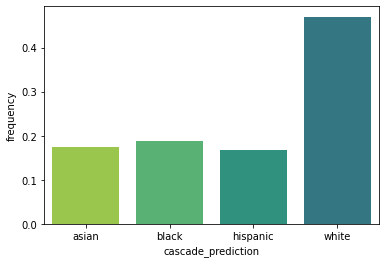

In [ ]:
print('Cascade 1')
sns.set_palette('viridis_r')

distribution_plot(cascade_1,'cascade_prediction')

In [ ]:
scoring(cascade_1,'race','cascade_prediction')

[0.78559888 0.69008765 0.83762984 0.65398324]
[0.1667524  0.59829657 0.83121586 0.76852885]
0.6923550280092857


As we can see, this model seems to have a higher relative distribution for asian relative to white; other than this Black and Hispanic names seem to have decent recall, Black names and Asian names have relatively lower precision, and the accuracy on average is 0.7 which is good but not great. 

### Preprocessed Cascade 1 

In [ ]:
preprocessed_cascade_1 = cascaded_predictor_1(cascade_df, preprocess=True)
sns.set_palette('viridis')
print('Preprocessed Cascade 1')
distribution_plot(preprocessed_cascade_1,'preprocessed_cascade_prediction')

FileNotFoundError: ignored

In [ ]:
scoring(preprocessed_cascade_1.dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

As we can see here the accuracy, recall, and precision all improved substantially. Average Accuracy is 0.2 higher (before it was 0.69).  
\** *note that these results are a bit exaggerated as our testing data was part of the preprocessed dataset as well* 

#### 'preprocessed' vs 'not preprocessed' names

In [ ]:
#sanity check - all preprocessed names should be score of 1 
scoring(preprocessed_cascade_1[preprocessed_cascade_1['preprocessed_race'].notnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_1[preprocessed_cascade_1['preprocessed_race'].isnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

## Cascade Model 1 (or statement at first) 


I wanted to see if we could naturally capture more 'white' names at first so that fewer are bucketed to asian at the end. This model is the same as the above model with the exception that we used 'or' instead of 'and' to make the 'white other' classification at the first step. 

In [ ]:
cascade_1_or = cascaded_predictor_1_or(cascade_df)
help(cascaded_predictor_1_or)

In [ ]:
print('Cascade 1 with or statement')
sns.set_palette('viridis_r')

distribution_plot(cascade_1_or,'cascade_prediction')

In [ ]:
scoring(cascade_1_or,'race','cascade_prediction')

As we can see here, asian names are now **underclassified,** as are black names. 

### Preprocessed Cascade 1 (or)

In [ ]:
preprocessed_cascade_1_or = cascaded_predictor_1_or(cascade_df, preprocess=True)
sns.set_palette('viridis')
print('Preprocessed Cascade 1')
distribution_plot(preprocessed_cascade_1_or,'preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_1_or.dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

As we can see here the accuracy, recall, and precision all improved substantially (especially for asian and black names). Average Accuracy is 0.2 higher (before it was 0.70). 

\** *note that these results are a bit exaggerated as our testing data was part of the preprocessed dataset as well* 


#### 'preprocessed' vs 'not preprocessed' names

In [ ]:
#sanity check - all preprocessed names should be score of 1 
scoring(preprocessed_cascade_1_or[preprocessed_cascade_1_or['preprocessed_race'].notnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_1_or[preprocessed_cascade_1_or['preprocessed_race'].isnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

## Cascade Model 2

We also wanted to look at a direct differentiation with white and black. Thus this model starts with asian names and then moves on to white vs black category in the end, as this is the hardest to classify between and we want to isolate out asian and hispanic names accurately. 

The first step (combined oversample and namsor for asian vs non asian) used classifiers with high recall. 

In [ ]:
cascade_2 = cascaded_predictor_2(cascade_df)
help(cascaded_predictor_2)
print('Cascade Model 2')
distribution_plot(cascade_2,'cascade_prediction')

In [ ]:
scoring(cascade_2,'race','cascade_prediction')

This model seems to overly categorize Black names, noted by the low precision. Also, Asian names are not very well classified. 

### Preprocessed Cascade 2

In [ ]:
preprocessed_cascade_2 = cascaded_predictor_2(cascade_df, preprocess=True)
sns.set_palette('viridis')
print('Preprocessed Cascade 1')
distribution_plot(preprocessed_cascade_2,'preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_2.dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

Once more this improves results greatly - though this preprocessed model is not as good as cascade model 1; precision at 0.73 isn't quite as high for Black names (As for preprocessed models for cascade 1 and cascade 1 with preprocessing) 

\** *note that these results are a bit exaggerated as our testing data was part of the preprocessed dataset as well* 


#### 'preprocessed' vs 'not preprocessed' names

In [ ]:
#sanity check - all preprocessed names should be score of 1 
scoring(preprocessed_cascade_2[preprocessed_cascade_2['preprocessed_race'].notnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_2[preprocessed_cascade_2['preprocessed_race'].isnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

## Cascade Model 3

Same as cascade model 2 but with inmate as the last step because inmate has very good recall for classifying Black names 

Help on function cascaded_predictor_3 in module __main__:

cascaded_predictor_3(df, preprocess=False)
    Function to compile cascade 
    Asian/NonAsian (combined_oversample_race & namsor) -> 
    Hispanic/Non-Hispanic (LR-Oversample & namsor) -> 
    Black/White (inmate & namsor)

Cascade 3


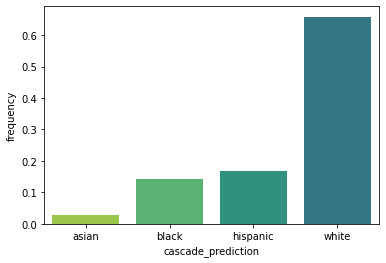

In [ ]:
cascade_3 = cascaded_predictor_3(cascade_df)
sns.set_palette('viridis_r')
help(cascaded_predictor_3)
print('Cascade 3')
distribution_plot(cascade_3,'cascade_prediction')

In [ ]:
scoring(cascade_3,'race','cascade_prediction')

[0.66519791 0.55909589 0.83762984 0.85459417]
[0.54787395 0.55815947 0.83121586 0.86223547]
0.8054139932135859


This one is naturally quite good (once more the recall for asian and black isn't quite as good).

### Preprocessed Cascade 3

In [ ]:
preprocessed_cascade_3 = cascaded_predictor_3(cascade_df, preprocess=True)
sns.set_palette('viridis')
print('Preprocessed Cascade 3')
distribution_plot(preprocessed_cascade_3,'preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_3.dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

This is our highest yet average accuracy. Note that the recall and precision for Black names is quite good and the precision is the highest it's been thus far. 

\** *note that these results are a bit exaggerated as our testing data was part of the preprocessed dataset as well* 


#### 'preprocessed' vs 'not preprocessed' names

In [ ]:
#sanity check - all preprocessed names should be score of 1 
scoring(preprocessed_cascade_3[preprocessed_cascade_3['preprocessed_race'].notnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_3[preprocessed_cascade_3['preprocessed_race'].isnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

## Cascade Model 4

This one differs from cascade models 2 and 3 by using high-precision models to classify asian vs non asian at the first step (still asian -> white)

In [ ]:
cascade_4 = cascaded_predictor_4(cascade_df)
sns.set_palette('viridis_r')
help(cascaded_predictor_4)
print('Model 2.3: Cascade Asian -> White')
distribution_plot(cascade_4,'cascade_prediction')

In [ ]:
scoring(cascade_4,'race','cascade_prediction')

this model has high average accuracy, but the precision and accuracy for classifying asian names is not very good. Similarly, the outcomes for Black names are at 0.55 precision and recall. 

### Preprocessed Cascade 4

In [ ]:
preprocessed_cascade_4 = cascaded_predictor_4(cascade_df, preprocess=True)
sns.set_palette('viridis')
print('Preprocessed Cascade 4')
distribution_plot(preprocessed_cascade_4,'preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_4.dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

This model is also quite good, with similar outcomes to the previous model. Precision and recall for asian names are a bit lower because not a lot of additional asian names were found. This may not be a bad thing however, as potentially many of the asian names identified in our cascade can also be preprocessed out naturally.  

#### 'preprocessed' vs 'not preprocessed' names

In [ ]:
#sanity check - all preprocessed names should be score of 1 
scoring(preprocessed_cascade_4[preprocessed_cascade_4['preprocessed_race'].notnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_4[preprocessed_cascade_4['preprocessed_race'].isnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

## Cascade Model 4 (or statement at first step)

This is Model 4 but with or statements as precision-based models tend to minimize classsifications when you also use 'and' statements.

In [ ]:
cascade_4_or = cascaded_predictor_4_or(cascade_df)
sns.set_palette('viridis_r')
help(cascaded_predictor_4_or)
distribution_plot(cascade_4_or,'cascade_prediction')

In [ ]:
scoring(cascade_4_or,'race','cascade_prediction')

this model doesn't appear to have particularly high recall or precision naturally. The precision further is actually much lower than for cascade 2 and 3, where the first step was based on top performing recall models (asian vs non asian) 

### Preprocessed Cascade 4

In [ ]:
preprocessed_cascade_4_or = cascaded_predictor_4_or(cascade_df, preprocess=True)
sns.set_palette('viridis')
print('Preprocessed Cascade 4 (or statement)')
distribution_plot(preprocessed_cascade_4_or,'preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_4_or.dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

#### 'preprocessed' vs 'not preprocessed' names

In [ ]:
#sanity check - all preprocessed names should be score of 1 
scoring(preprocessed_cascade_4_or[preprocessed_cascade_4_or['preprocessed_race'].notnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_4_or[preprocessed_cascade_4_or['preprocessed_race'].isnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

## Run Cascade Model 5

In [ ]:
cascade_5 = cascaded_predictor_5(cascade_df)
sns.set_palette('viridis_r')

help(cascaded_predictor_5)
print('Cascade ')
distribution_plot(cascade_5,'cascade_prediction')

In [ ]:
scoring(cascade_5,'race','cascade_prediction')

### Preprocessed Cascade 5

In [ ]:
preprocessed_cascade_5 = cascaded_predictor_5(cascade_df, preprocess=True)
sns.set_palette('viridis')
print('Preprocessed Cascade 4 (or statement)')
distribution_plot(preprocessed_cascade_5,'preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_5.dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

#### 'preprocessed' vs 'not preprocessed' names

In [ ]:
#sanity check - all preprocessed names should be score of 1 
scoring(preprocessed_cascade_5[preprocessed_cascade_5['preprocessed_race'].notnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_5[preprocessed_cascade_5['preprocessed_race'].isnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

## Cascade Model 5 (or statement at first step)

In [ ]:
cascade_5_or = cascaded_predictor_5_or(cascade_df)
sns.set_palette('viridis_r')
help(cascaded_predictor_5_or)
print('Model 2.4: Cascade Black -> Asian')
distribution_plot(cascade_5_or,'cascade_prediction')

In [ ]:
scoring(cascade_5_or,'race','cascade_prediction')

### Preprocessed Cascade 5 (or statement at first step) 

In [ ]:
preprocessed_cascade_5_or = cascaded_predictor_5_or(cascade_df, preprocess=True)
sns.set_palette('viridis')
print('Preprocessed Cascade 5 (or statement)')
distribution_plot(preprocessed_cascade_5_or,'preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_5_or.dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

#### 'preprocessed' vs 'not preprocessed' names

In [ ]:
#sanity check - all preprocessed names should be score of 1 
scoring(preprocessed_cascade_5_or[preprocessed_cascade_4_or['preprocessed_race'].notnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_5_or[preprocessed_cascade_4_or['preprocessed_race'].isnull()].dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')

## Run Cascade Model 6

Help on function cascaded_predictor_6 in module __main__:

cascaded_predictor_6(df, preprocess=False)
    Function to compile cascade 
    Black/NonBlack (namsor & inmate) -> 
    Hispanic/Non-Hispanic (nameprism & namsor) -> 
    Asian/White (LR-Oversample & namsor)

Cascade 


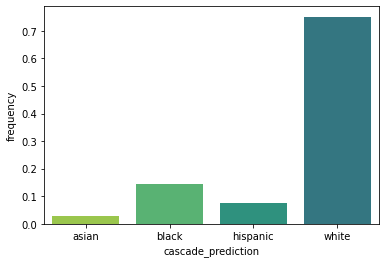

In [ ]:
cascade_6 = cascaded_predictor_6(cascade_df)
sns.set_palette('viridis_r')

help(cascaded_predictor_6)
print('Cascade ')
distribution_plot(cascade_6,'cascade_prediction')

In [ ]:
scoring(cascade_6,'race','cascade_prediction')

[0.66519791 0.55909589 0.36974303 0.87507148]
[0.54787395 0.55815947 0.50821569 0.8251133 ]
0.7414971135411139


### Preprocessed Cascade 6

In [ ]:
preprocessed_cascade_6 = cascaded_predictor_6(cascade_df, preprocess=True)
sns.set_palette('viridis')
print('Preprocessed Cascade 6 (or statement)')
distribution_plot(preprocessed_cascade_6,'preprocessed_cascade_prediction')

In [ ]:
scoring(preprocessed_cascade_6.dropna(subset=['preprocessed_cascade_prediction']),'race','preprocessed_cascade_prediction')